<a href="https://colab.research.google.com/github/lianluoliang/data-science/blob/main/iq_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed

Epoch 1/10


30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.1233 - val_loss: 0.0212
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0073 - val_loss: 3.5975e-04
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0014 - val_loss: 8.3262e-05
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0012 - val_loss: 8.2028e-05
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0011 - val_loss: 7.3232e-05
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0015 - val_loss: 7.1216e-05
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0015 - val_loss: 6.9580e-05
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0011 - val_loss: 6.8997e-05
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0011 - val_loss: 6.9118e-05
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0011 - val_loss: 7.2302e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━

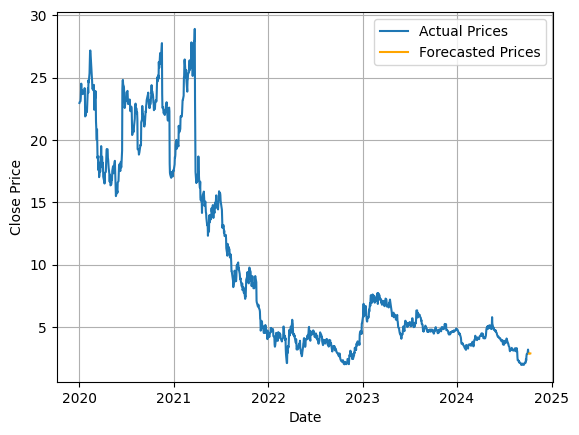

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, GRU, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping
import matplotlib.pyplot as plt
import yfinance as yf
# Download historical stock data for iQiyi
data = yf.download('IQ', start='2020-01-01', end='2024-10-04')
# Reset index to make 'Date' a column
data = data.reset_index()
data.set_index('Date', inplace=True)
# Step 1: Data Preparation
# Extract 'Close/Last' and scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Create sequences (X) and targets (y)
sequence_length = 30  # We use the past 30 days to predict the next day
X, y = [], []
for i in range(sequence_length, len(scaled_close)):
    X.append(scaled_close[i-sequence_length:i, 0])
    y.append(scaled_close[i, 0])

X, y = np.array(X), np.array(y)

# Reshape X to fit the GRU model (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Step 2: Build the GRU model
gru_model = Sequential()
# Add a new input layer
gru_model.add(Input(shape=(X.shape[1], 1)))  # Define input shape using Input layer
gru_model.add(GRU(units=50, return_sequences=True))
gru_model.add(GRU(units=50))
gru_model.add(Dense(1))  # Output layer

# Compile the model
optimizer= keras.optimizers.Adam(learning_rate=0.0005)
gru_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Step 3: Train the GRU model with Early Stopping
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# monitor: Metric to monitor (usually 'val_loss' for validation loss)
# patience: Number of epochs with no improvement before stopping
# restore_best_weights: Restore model weights from the epoch with the best value of the monitored quantity

# Fit the model with the EarlyStopping callback
gru_model.fit(X, y, epochs=10, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Step 4: Forecasting
# Prepare the last sequence of 30 days to predict future values
last_sequence = scaled_close[-sequence_length:]
last_sequence = np.reshape(last_sequence, (1, sequence_length, 1))

# Predict the next 6 days (for October 6 to October 11, 2024)
forecast_gru_scaled = []
for _ in range(6):
    predicted_scaled = gru_model.predict(last_sequence)
    forecast_gru_scaled.append(predicted_scaled[0, 0])

    # Update the sequence with the predicted value (maintain 3D shape)
    last_sequence = np.append(last_sequence[:, 1:, :], predicted_scaled.reshape(1, 1, 1), axis=1)

# Inverse scale the predicted values back to original scale
forecast_gru = scaler.inverse_transform(np.array(forecast_gru_scaled).reshape(-1, 1))

# Prepare forecast dates
forecast_dates = pd.date_range(start='2024-10-06', periods=6)

# Create a DataFrame with forecasted values
forecast_results = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Close': forecast_gru.flatten()
})

# Display the forecasted results
print(forecast_results)

# Optional: Plot the forecasted results
plt.plot(data.index, data['Close'], label='Actual Prices')
plt.plot(forecast_results['Date'], forecast_results['Forecasted_Close'], label='Forecasted Prices', color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0831
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0031
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0013
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 9.0531e-04
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0010
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0010
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 9.2388e-04
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 8.9430e-04
Epoch 9/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 9.9147e-04
Epoch 10/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 7.5806e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


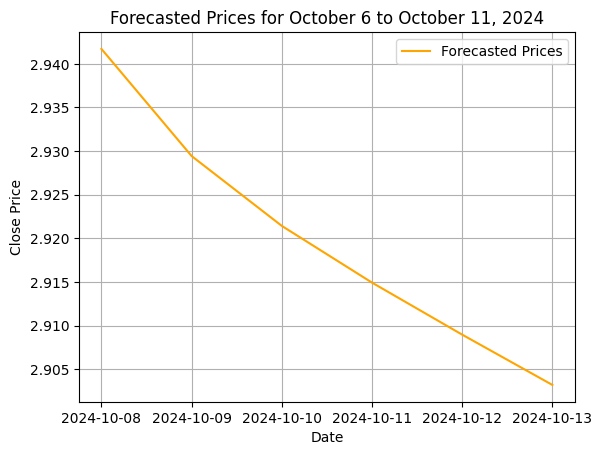

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input
import matplotlib.pyplot as plt
import keras
import yfinance as yf
import datetime
# Download historical stock data for iQiyi
# Get today's date
today = datetime.date.today()
# Format the date as 'YYYY-MM-DD'
end_date = today.strftime('%Y-%m-%d')
data = yf.download('IQ', start='2020-01-01', end=end_date)
# Reset index to make 'Date' a column
data = data.reset_index()
data.set_index('Date', inplace=True)

# Step 1: Data Preparation
# Extract 'Close/Last' and scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Create sequences (X) and targets (y)
sequence_length = 30  # We use the past 30 days to predict the next day
X, y = [], []
for i in range(sequence_length, len(scaled_close)):
    X.append(scaled_close[i-sequence_length:i, 0])
    y.append(scaled_close[i, 0])

X, y = np.array(X), np.array(y)

# Reshape X to fit the GRU model (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Step 2: Build the GRU model
gru_model = Sequential()
#INPUT A NEW LAYER
gru_model.add(Input(shape=(X.shape[1], 1)))  # Define input shape using Input layer
gru_model.add(GRU(units=50, return_sequences=True))
gru_model.add(GRU(units=50))
gru_model.add(Dense(1))  # Output layer
optimizer= keras.optimizers.Adam(learning_rate=0.0005)

# Compile the model
gru_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Step 3: Train the GRU model
gru_model.fit(X, y, epochs=10, batch_size=32, verbose=1)

# Step 4: Forecasting
# Prepare the last sequence of 30 days to predict future values
last_sequence = scaled_close[-sequence_length:]
last_sequence = np.reshape(last_sequence, (1, sequence_length, 1))

# Predict the next 6 days (for October 6 to October 11, 2024)
forecast_gru_scaled = []
for _ in range(6):
    predicted_scaled = gru_model.predict(last_sequence)
    forecast_gru_scaled.append(predicted_scaled[0, 0])

    # Update the sequence with the predicted value (maintain 3D shape)
    last_sequence = np.append(last_sequence[:, 1:, :],  predicted_scaled.reshape(1, 1, 1), axis=1)

# Inverse scale the predicted values back to original scale
forecast_gru = scaler.inverse_transform(np.array(forecast_gru_scaled).reshape(-1, 1))

# Prepare forecast dates
forecast_dates = pd.date_range(start='2024-10-08', periods=6)

# Create a DataFrame with forecasted values
forecast_results = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Close': forecast_gru.flatten()
})

# Plot only the forecasted results
plt.plot(forecast_results['Date'], forecast_results['Forecasted_Close'], label='Forecasted Prices', color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.title('Forecasted Prices for October 6 to October 11, 2024')
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on the training data (X)
train_predictions_scaled = gru_model.predict(X)

# Inverse scaling to get predictions back in original scale
train_predictions = scaler.inverse_transform(train_predictions_scaled)
y_true = scaler.inverse_transform(y.reshape(-1, 1))

# Calculate evaluation metrics
mse = mean_squared_error(y_true, train_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, train_predictions)
mape = np.mean(np.abs((y_true - train_predictions) / y_true)) * 100

# Print out the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Mean Squared Error (MSE): 0.5471823220227824
Root Mean Squared Error (RMSE): 0.7397177313156569
Mean Absolute Error (MAE): 0.4646667976510147
Mean Absolute Percentage Error (MAPE): 6.240090887824999%


[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

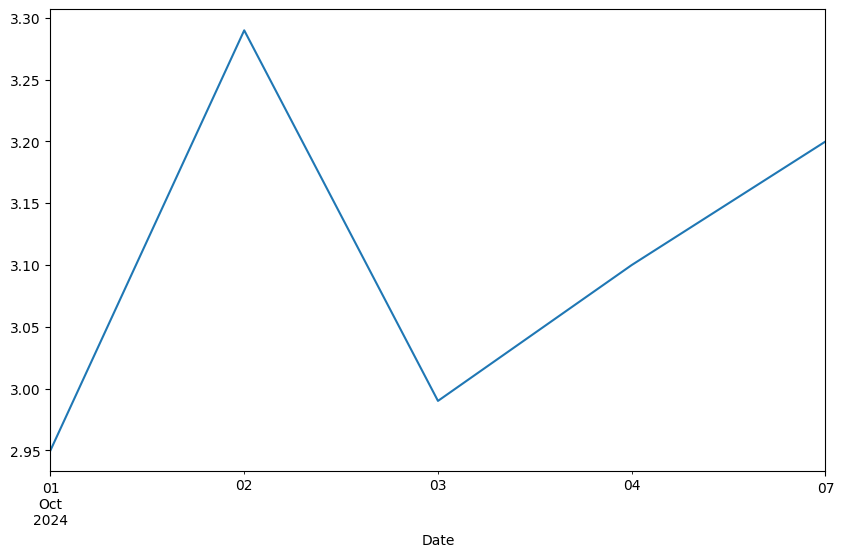

In [ ]:
import pandas as pd
import yfinance as yf

data = yf.download('IQ', start='2024-10-01', end='2024-10-08')
data['Open'].plot(figsize=(10, 6))


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data['Open'], order=(5, 1, 0))  # order (p,d,q)
model_fit = model.fit()
forecast = model_fit.get_forecast(steps=6) # get_forecast method is used for prediction
print(forecast.predicted_mean) # Accessing the mean of the prediction interval

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


2024-10-08    2.907072
2024-10-09    3.247632
2024-10-10    2.978787
2024-10-11    3.042780
2024-10-14    3.189920
2024-10-15    2.873499
Freq: B, Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


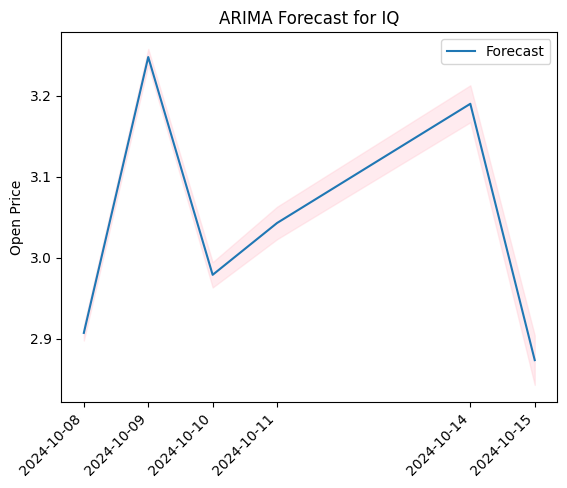

In [ ]:
import matplotlib.pyplot as plt
# Get predicted means from the forecast object
predicted_means = forecast.predicted_mean

# Get predicted means from the forecast object
predicted_means = forecast.predicted_mean

# Get the confidence intervals (assuming you have them calculated)
conf_int = forecast.conf_int()
# Create a figure and axes object
fig, ax = plt.subplots()
# Now you can plot using the predicted means
plt.plot(predicted_means, label='Forecast')
plt.fill_between(predicted_means.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
# Set custom x-axis ticks and labels
ax.set_xticks(predicted_means.index)  # Set ticks at the dates
ax.set_xticklabels(predicted_means.index.strftime('%Y-%m-%d'), rotation=45, ha='right')  # Format labels

plt.ylabel("Open Price")
plt.legend()
plt.title('ARIMA Forecast for IQ')
plt.show()